In [1]:
import numpy as np
from numpy import log2
from scipy import signal
import matplotlib.pyplot as plt

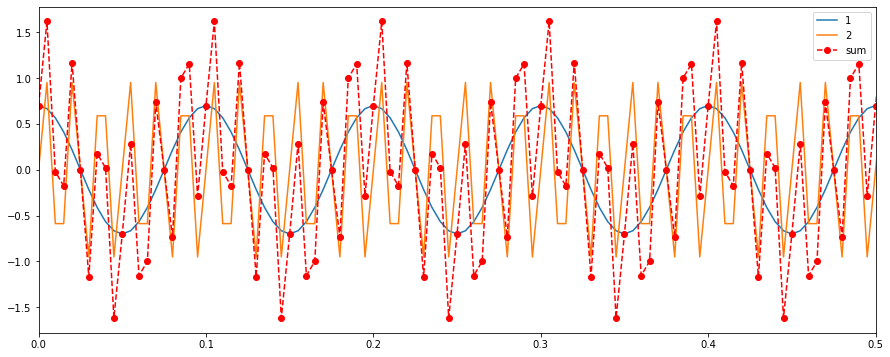

In [2]:
sample_rate = 200
nsamples = 400
freq_camp = sample_rate/nsamples
t = np.arange(nsamples) / sample_rate
ys1 = 0.7*np.cos(2*np.pi*10*t)  # 10/400 = 0.025
ys2 = np.sin(2*np.pi*60*t)  # 60/400 = 0.15 > 0.1

plt.figure(figsize=(15,6))
plt.plot(t,ys1,label='1')
plt.plot(t,ys2,label='2')
plt.plot(t,ys2+ys1,'r--o',label='sum')
plt.xlim(0,0.5)
plt.legend()

plt.show()

In [3]:
numtaps = 6
f = 0.03             #cut-off freq
taps= signal.firwin(numtaps, f)

print('coeff_1 = ', taps)


coeff_1 =  [0.02856076 0.14288273 0.32855651 0.32855651 0.14288273 0.02856076]


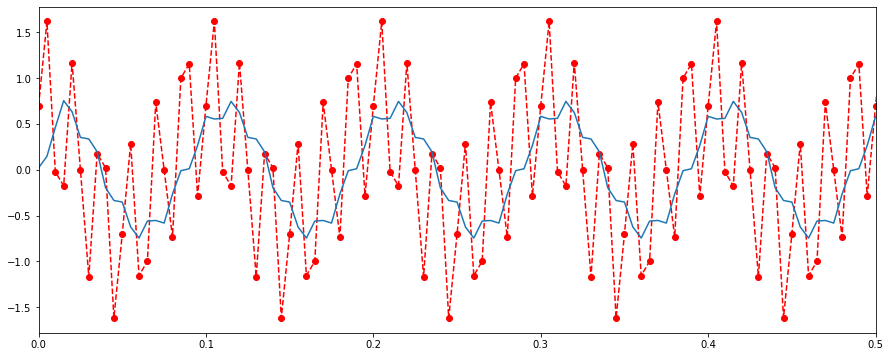

In [4]:
filtered_y = signal.lfilter(taps, 1, ys1+ys2)

plt.figure(figsize=(15,6))
plt.plot(t,ys2+ys1,'r--o',label='sum')
plt.plot(t,filtered_y )
plt.xlim(0,0.5)

plt.show()

In [5]:
def computeQ(y,taps):
    M = max(max(np.abs(taps)),max(np.abs(y)))
    Q = log2(127) - log2(M)
    return Q

def double_to_signed(a, Q):
    int_a = np.round(a*2**Q)
    signed = np.where(int_a >= 0, int_a, int_a + 256).astype(int)
    return signed
    
def signed_to_double(a,Q):
    signed = np.where(a >= 128, a-256, a)
    double_a = signed*2**(-Q)
    return double_a

def signed_to_double2(a,Q):
    signed = np.where(a >= 128, a-256, a)
    #new_Q = computeQ(a, np.array([0]))
    double_a = signed*2**(-Q) 
    return double_a

In [6]:
"""def computeQ(y,taps):
    M = max(max(np.abs(taps)),max(np.abs(y)))
    Q = log2(127) - log2(M)
    return Q

def double_to_signed(a, Q): #only one element each time
    int_a = int(a*2**Q)
    signed =0
    if int_a >= 0: signed = int_a
    if int_a <0: signed= int_a + 256
    return int(signed)

def signed_to_double(a,Q):
    signed=0
    if a>= 128 : signed = a-256
    if a<128 : signed = a

    double_a = signed*2**(-Q)
    return double_a
"""

'def computeQ(y,taps):\n    M = max(max(np.abs(taps)),max(np.abs(y)))\n    Q = log2(127) - log2(M)\n    return Q\n\ndef double_to_signed(a, Q): #only one element each time\n    int_a = int(a*2**Q)\n    signed =0\n    if int_a >= 0: signed = int_a\n    if int_a <0: signed= int_a + 256\n    return int(signed)\n\ndef signed_to_double(a,Q):\n    signed=0\n    if a>= 128 : signed = a-256\n    if a<128 : signed = a\n\n    double_a = signed*2**(-Q)\n    return double_a\n'

In [7]:
y = ys1 + ys2
Q = computeQ(y, taps)
#signed = double_to_signed(y,Q)
#double = signed_to_double(signed,Q)
"""
plt.figure(figsize=(15,6))
plt.plot(t,y, 'r--o')
plt.plot(t,double, 'bo')
plt.xlim(1,1.5)
plt.show()"""

"\nplt.figure(figsize=(15,6))\nplt.plot(t,y, 'r--o')\nplt.plot(t,double, 'bo')\nplt.xlim(1,1.5)\nplt.show()"

In [8]:
Q = computeQ(y, taps)
#integer_taps = double_to_signed(taps, Q)
#print([bin(i) for i in integer_taps])

In [9]:
"""Q = computeQ(y, taps)
y_signal_singed=[int(double_to_signed(i,Q)) for i in y]

#print(y_signal_singed[:25])

y0=y_signal_singed[:25]
y1=y_signal_singed[25:50]
y2=y_signal_singed[50:75]
y3=y_signal_singed[75:100]
y4=y_signal_singed[100:125]
y5=y_signal_singed[125:150]
y6=y_signal_singed[150:175]
y7=y_signal_singed[175:200]
y8=y_signal_singed[200:225]
y9=y_signal_singed[225:250]
y10=y_signal_singed[250:275]
y11=y_signal_singed[275:300]
y12=y_signal_singed[300:325]
y13=y_signal_singed[325:350]
y14=y_signal_singed[350:375]
y15=y_signal_singed[375:400]

ypsi=[y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15]

#for i in range(16):
 #   np.savetxt("signal{}.txt".format(i), ypsi[i],fmt='%1u')"""

'Q = computeQ(y, taps)\ny_signal_singed=[int(double_to_signed(i,Q)) for i in y]\n\n#print(y_signal_singed[:25])\n\ny0=y_signal_singed[:25]\ny1=y_signal_singed[25:50]\ny2=y_signal_singed[50:75]\ny3=y_signal_singed[75:100]\ny4=y_signal_singed[100:125]\ny5=y_signal_singed[125:150]\ny6=y_signal_singed[150:175]\ny7=y_signal_singed[175:200]\ny8=y_signal_singed[200:225]\ny9=y_signal_singed[225:250]\ny10=y_signal_singed[250:275]\ny11=y_signal_singed[275:300]\ny12=y_signal_singed[300:325]\ny13=y_signal_singed[325:350]\ny14=y_signal_singed[350:375]\ny15=y_signal_singed[375:400]\n\nypsi=[y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15]\n\n#for i in range(16):\n #   np.savetxt("signal{}.txt".format(i), ypsi[i],fmt=\'%1u\')'

In [10]:
tmp = double_to_signed(y[:7], Q)
print([bin(i) for i in tmp])

['0b110111', '0b1111111', '0b11111110', '0b11110010', '0b1011100', '0b0', '0b10100100']


In [11]:
#print(y)
#signal_to = np.loadtxt("signal.txt")
#print(y-signal_to)

## find maximum

In [12]:
s_max = max(double_to_signed(y, Q))
t_max = max(double_to_signed(taps, Q))

mult = s_max * np.sum(double_to_signed(taps,Q)) 
print(bin(mult))

0b100110101100100


## comparison

In [13]:
#reconstruct
fil_fpga=[]
for i in range(16):
    tmp=np.loadtxt("filtered_signal{}.txt".format(i))
    for n in tmp:
        fil_fpga.append(n)

fil_fpga=np.array(fil_fpga)
fil_fpga_reco=signed_to_double(fil_fpga,Q=Q)*max(y)
print(len(fil_fpga_reco))

400


25
26
27
28
50
51
52
53
375
376


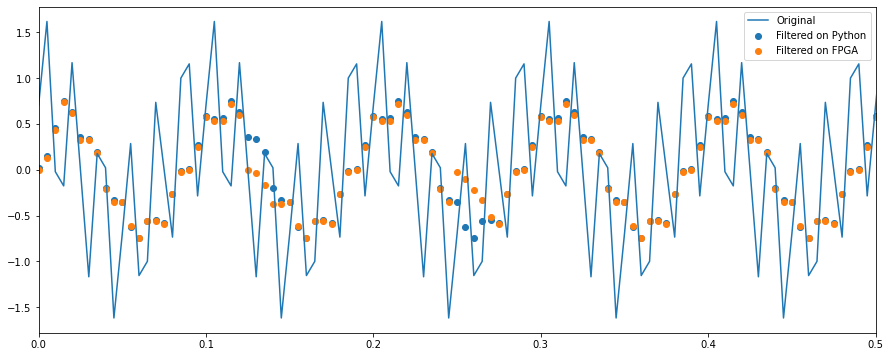

In [18]:
#filtered_by_fpga = np.loadtxt("filtered_signal2.txt") ###changed name

plt.figure(figsize=(15,6))
plt.plot(t, y, label="Original")
plt.scatter(t, filtered_y, label="Filtered on Python")
plt.scatter(t, fil_fpga_reco, label="Filtered on FPGA")
#plt.scatter(t[379], fil_fpga_reco[379], label="Filtered on FPGA")
plt.legend()
plt.xlim(0,0.5)

#print(np.abs(filtered_y[375] - fil_fpga_reco[375]))
for i in range(400):
    if np.abs(filtered_y[i]-fil_fpga_reco[i]) > 0.1: print (i)

I do not understand why it works for some time and then it stop..

In [ ]:
#max_y = np.max(y)
#print(max_y)

In [1]:
arr = [0b0000000, 0b00000110, 0b000010110, 0b000100100, 0b000011110, 0b00010000, 0b00010000]
arr = np.array([ord(chr(a)) for a in arr])
sig1 = signed_to_double(arr, Q)
sig2 = signed_to_double(arr, Q-1)
sig3 = signed_to_double2(arr,Q) * max_y 


NameError: name 'np' is not defined

In [ ]:
sig3-filtered_y[:7]

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(t[:7], sig1, label="sig1")
plt.plot(t[:7], sig2, label="sig2")
plt.plot(t[:7], sig3, label="sig3")
plt.plot(t[:7], filtered_y[:7], label="python")
#plt.plot(t[:7], filtered_by_fpga[:7], label="fpga")
plt.legend()
plt.grid(True)

## Attempt for studying the approximation done

In [ ]:
series = np.linspace(-1, 1, 1001)
Q = computeQ(series, taps)
transformed = signed_to_double(double_to_signed(series, Q), Q)
plt.figure(figsize=(15,6))
plt.plot(series, series-transformed)
plt.xlim(-1, 0.5)

discrepancy = series - transformed
print(max(discrepancy), min(discrepancy))

disc_pos = discrepancy[discrepancy > 0]
plt.figure(figsize=(15,6))
plt.plot(series[discrepancy > 0], disc_pos)
plt.xlim(-1, 0.5)
print(max(disc_pos), min(disc_pos))